Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

import utils

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
boxsize = experiment.environments[0].boxsize

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_all_clusters.npz")
print(module_indices.files)
clusters = [module_indices[f] for f in module_indices.files]

# print number of cells in each cluster
for cluster in clusters:
    print(len(cluster))

['rotation_cluster_-1', 'rotation_cluster_0', 'rotation_cluster_1', 'rotation_cluster_2', 'rotation_cluster_3', 'rotation_cluster_4', 'rotation_cluster_5', 'rotation_cluster_6', 'rotation_cluster_7', 'rotation_cluster_8', 'rotation_cluster_9', 'rotation_cluster_10', 'rotation_cluster_11', 'rotation_cluster_12', 'rotation_cluster_13', 'rotation_cluster_14', 'rotation_cluster_15', 'rotation_cluster_16']
199
85
518
83
848
614
46
40
84
79
103
138
55
95
43
31
39
31


In [5]:
def load_model(experiment, random_model=False):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    if not random_model:
        model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)
random_model = load_model(experiment, random_model=True)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999
Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [6]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=20)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [7]:
def pred_inference(model, inputs, labels, positions, indices, trajectory_slice=None):
    trajectory_slice = slice(0,positions.shape[1]) if trajectory_slice is None else trajectory_slice
    position_slice = slice(trajectory_slice.start,trajectory_slice.stop+1)
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions[:,trajectory_slice], 
                                      positions[:,position_slice], indices, model.place_cell_ensembles)
    return pred_error.item()

In [8]:
def prune_model(model, dataloader, clusters, nsteps=60, trajectory_slice=slice(19,20), ncells2prune=6):
    errors = np.zeros((len(clusters), nsteps))
    # bag/hat to keep continuous pruning idxs in
    cluster_idxs = [[]]*len(clusters)

    i = 0
    for inputs, labels, positions, indices in dataloader:
        if i == nsteps:
            break

        # clusters
        for j, cluster in enumerate(clusters):
            remaining = list(set(cluster) - set(cluster_idxs[j]))
            if len(remaining) == 0:
                continue
            tmp = np.random.choice(remaining, size=ncells2prune if len(remaining) > ncells2prune else len(remaining), replace=False)
            cluster_idxs[j] = np.append(cluster_idxs[j], tmp).astype(int)
            model.prune_mask = cluster_idxs[j]
            errors[j,i] = pred_inference(model, inputs, labels, positions, indices, trajectory_slice=trajectory_slice)

        i+=1
            
    return errors

In [9]:
def prune_stats(nstats, model, dataloader, clusters, **kwargs):
    stats = []
    for j in tqdm.trange(nstats):
        stats.append(prune_model(model, dataloader, clusters, **kwargs))
    return np.array(stats) # shape: (nstats x 6 x nsteps)

In [10]:
nsteps = 60 
nstats = 30
load_stats = True

if load_stats:
    with open(experiment.paths['experiment'] / "pruning_errors_all_clusters.pkl", "rb") as f:
        pruning_errors = pickle.load(f)
else:
    pruning_errors = prune_stats(nstats, model, dataloader, clusters, nsteps=nsteps, trajectory_slice=slice(19,20))
    # save pruning errors statistics - since it takes so long to compute it can be loaded instead
    with open(experiment.paths['experiment'] / "pruning_errors_all_clusters.pkl", "wb") as f:
        pickle.dump(pruning_errors, f)

100%|██████████| 30/30 [1:39:33<00:00, 199.12s/it]


In [16]:
pruning_errors.shape

(30, 18, 60)

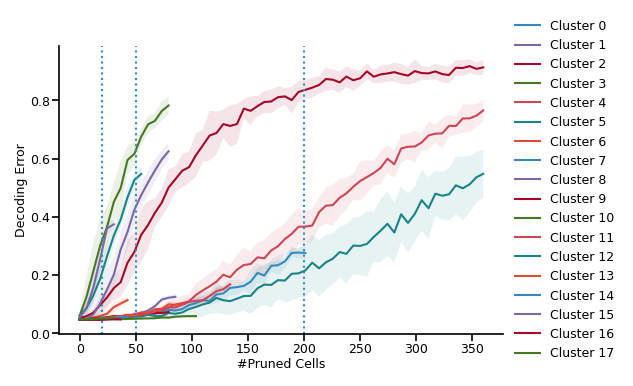

In [86]:
figsize = set_size(mode='tall', fraction=(1,1/3))

fig, ax = plt.subplots(figsize=figsize)
x_ticks = np.linspace(0, 360, nsteps)
labels = [f"Cluster {i}" for i in range(len(clusters))]
ls = ['-']*len(labels)

mean_error = np.mean(pruning_errors,axis=0)
std_error = np.std(pruning_errors,axis=0)
median_error = np.median(pruning_errors,axis=0)
mad_error = mad(pruning_errors,axis=0)
median_error[median_error==0] = np.nan
mad_error[mad_error==0] = np.nan
for i in range(len(labels)): # set order to change color according to color-cycler
    #ax.plot(x_ticks, mean_error[i], label=labels[i])#np.mean(pruning_i,axis=0))
    #ax.fill_between(x_ticks, mean_error[i] + std_error[i], mean_error[i] - std_error[i], alpha=0.1)
    ax.plot(x_ticks, median_error[i], label=labels[i], ls=ls[i])#np.mean(pruning_i,axis=0))
    ax.fill_between(x_ticks, median_error[i] + mad_error[i], median_error[i] - mad_error[i], alpha=0.1)

#ax.scatter(x_ticks[None]*np.ones((30,1)), pruning_errors[:,1], s=5, alpha=0.5, c=ax.lines[-1].get_color())


ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('#Pruned Cells')
ax.set_ylabel('Decoding Error')

ax.axvline(20, ls=':')
ax.axvline(50, ls=':')
ax.axvline(200, ls=':')

#fig.savefig("/home/vemundss/Desktop/prune")
#fig.savefig(experiment.paths['experiment'] / f'plots/pruning')
fig.savefig(experiment.paths['experiment'] / f'plots/pruning_all_clusters')


In [56]:
ratemaps = utils.load_ratemaps(experiment)
ratemaps.shape

(3, 4096, 64, 64)

In [89]:


print(sum([len(cluster) for cluster in clusters]))



3131


(1.1934412619344126, 0.9547530095475301)


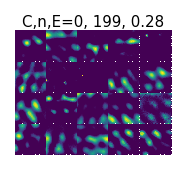

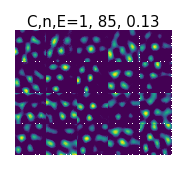

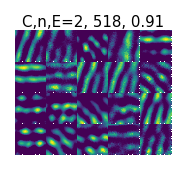

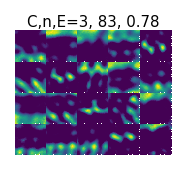

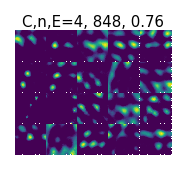

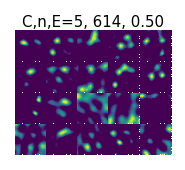

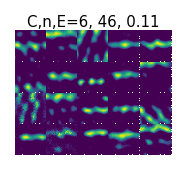

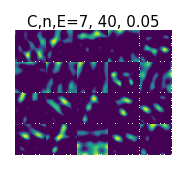

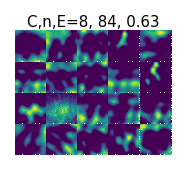

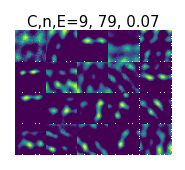

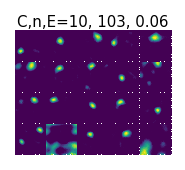

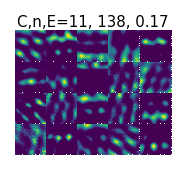

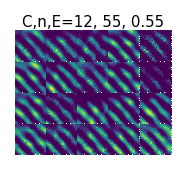

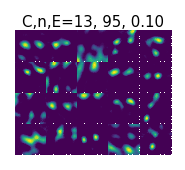

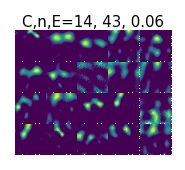

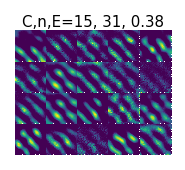

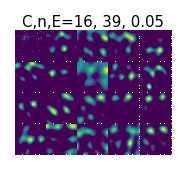

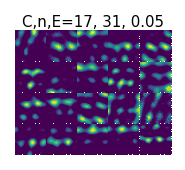

In [88]:
figsize = set_size(fraction=(1,2/3),mode='tall')
figsize = np.ones(2)*min(figsize) # make square on the short axis
figsize = (figsize[0]*1/4, figsize[1]*1/5) # five clusters per column, four clusters per row
print(figsize)

for i in range(len(clusters)):
    fig, axs = multiimshow2(ratemaps[0,clusters[i]][:20],figsize=figsize,normalize=False);
    fig.suptitle(f"C,n,E={i}, {len(clusters[i])}, {np.max(mean_error[i]):.2f}")
    fig.savefig(experiment.paths['experiment'] / f'plots/pruning_cluster_{i}')

### Investigate pruning distribution

In [ ]:
prune_type_id = 1

for i in range(pruning_errors.shape[-1]):
    fig,ax = plt.subplots()
    ax.hist(pruning_errors[:,prune_type_id,i])
    m = np.mean(pruning_errors,axis=0)[prune_type_id,i]
    s = np.std(pruning_errors,axis=0)[prune_type_id,i]
    med = np.median(pruning_errors,axis=0)[prune_type_id,i]
    ma = mad(pruning_errors,axis=0)[prune_type_id,i]
    ax.axvline(m, color='green')
    ax.axvline(m + s, color='red')
    ax.axvline(m - s, color='red')
    
    ax.axvline(med, ls=':', color='green')
    ax.axvline(med + ma, ls=':', color='red')
    ax.axvline(med - ma, ls=':', color='red')
    #ax.set_title(np.mean())

In [ ]:
np.min(pruning_errors,axis=0)[1], np.max(pruning_errors,axis=0)[1]

In [ ]:
x_ticks = np.linspace(0, ncells, len(pe_true))
plt.plot(x_ticks, pe_true, label='Full Model')
plt.plot(x_ticks, pe_random, label='Random Pruning')
plt.plot(x_ticks, pe_gcs, label='High GCS Pruning')
plt.plot(x_ticks, pe_random_torus, label='Random Torus Pruning')
#plt.plot(x_ticks, pe_sorted_torus, label='Sorted Torus Pruning')
plt.plot(x_ticks, pe_random_inverse_torus, label='Random Inverse Torus Pruning')
plt.legend()
plt.xlabel('#Pruned Cells')
plt.ylabel('Decoding Error')

plt.savefig("/home/vemundss/Desktop/prune")
plt.savefig(experiment.paths['experiment'] / f'plots/pruning')

In [ ]:
# NEXT
# -- DONE -- prune with high GCS
# -- DONE -- prune toroid cells sorted on phase - physics phase transtition?
# legg til error shadings på grafene.
# include adverserial attack?
# -- DONE -- prune inverse of toroid cells. path integration remain? ratemaps still grids? toroid still there?
# select phases based on e.g. right side of box.

# Include random initialised network without pruning to show baseline decoding error